In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  # import the curve fitting function
%matplotlib inline

## Read/Sort Data

In [32]:
df = pd.read_excel('Data.xlsx', sheetname=None)

In [33]:
df['1000V']

,x(cm),positive y(tic),negative y(tic),uncertainty +/- (tic),offset (tic),tic length (m),current (A),current uncertainty (A),voltage (V),voltage uncertainty (V)
0,2,0.625,-1.00,0.25,-0.25,0.002,0.31,0.01,1000,1
1,4,1.875,-2.50,0.25,-0.25,NaN,NaN,NaN,NaN,NaN
2,6,4.000,-4.50,0.25,-0.25,NaN,NaN,NaN,NaN,NaN
3,8,6.500,-7.25,0.25,-0.25,NaN,NaN,NaN,NaN,NaN
4,10,10.000,-10.50,0.50,0.00,NaN,NaN,NaN,NaN,NaN


In [34]:
keys = ['1000V','1500V','2000V','2500V','3000V']

In [35]:
xpoints = np.array([df[key]['x(cm)'] for key in keys]) #Same x points at all voltages

#Convert x (cm) to meters
xpoints = xpoints*1e-2

tic_length = df['1000V']['tic length (m)'][0] #Length of ticks on paper

y_uncertainty = np.array(df['1000V']['uncertainty +/- (tic)']) #Eyeball measurement

#convert y_uncertainty from ticks to meters
y_uncertainty = y_uncertainty*tic_length

i_uncertainty = df['1000V']['current uncertainty (A)'][0]
v_uncertainty = df['1000V']['voltage uncertainty (V)'][0]


offsets = np.array([df[key]['offset (tic)'] for key in keys]) #At V=0, the beam wasn't quite through y = 0.
#Convert ticks to meters
offsets = offsets*tic_length


In [36]:
y_up = np.array([df[key]['positive y(tic)'] for key in keys]) #Upward deflection in ticks.
y_down = np.array([df[key]['negative y(tic)'] for key in keys])#Downward

#Convert ticks to meters
y_up = y_up*tic_length
y_down = y_down*tic_length

#Correct for offset
y_up = y_up - offsets
y_down = y_down - offsets

#Average to account for alignment
ypoints = (1/2)*(y_up + abs(y_down))

currents = np.array([df[key]['current (A)'][0] for key in keys]) #Amps
voltages = np.array([df[key]['voltage (V)'][0] for key in keys], dtype=int) #Voltes

## Plot Data

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


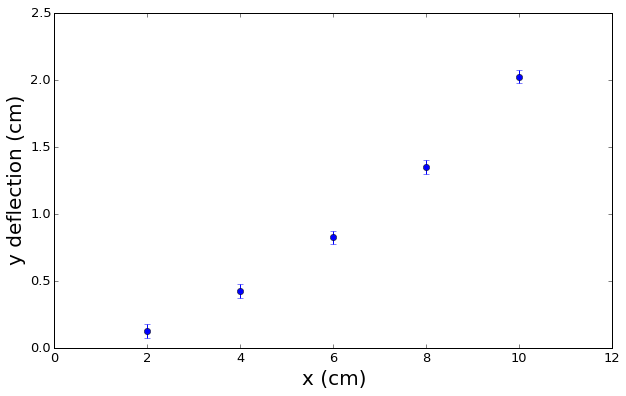

In [37]:
plt.figure(figsize=(10,6));
plt.errorbar(xpoints[1]*100,ypoints[1]*100,y_uncertainty[1]*100,linestyle = '',marker = 'o');
plt.xlabel('x (cm)',fontsize=20);
plt.ylabel('y deflection (cm)',fontsize = 20);
plt.xlim(0,12);
plt.xticks(size = 13);
plt.yticks(size = 13);
plt.savefig('Sample')

## Curve fit to find the radius of curvature

The electron is deflected radially by the field.  
The equation of a circle with radius $a$ centered at $(x,y)=(b,c)$ is given by
$$(x-b)^2+(y-c)^2 = a^2$$
Let's rewrite this in terms of $y$,
$$y=-\sqrt{a^2-(x-b)^2}+c$$
We define the function and then want to find the best estimates for $a, b, c$ consistent with our data.

In [38]:
def myfun(x,a,b,c):
    ans = -np.sqrt(a**2-(x-b)**2)+c  # this is y, "the function to be fit"
    return ans

In [39]:
p0 = [.15, 0, .15]

In [40]:
#Initialize arrays to hold a,b,c for all data
a = np.zeros(len(xpoints)) #Radius
ea = np.zeros(len(xpoints)) #uncertainty
b = np.zeros(len(xpoints)) #x shift
eb = np.zeros(len(xpoints))
c = np.zeros(len(xpoints)) #y shift
ec = np.zeros(len(xpoints))

In [41]:
xlots = np.linspace(.5e-2,11e-2)  # need lots of data points for smooth curve
yfit = np.zeros((len(xpoints),xlots.size))

for i in np.arange(0,len(xpoints)): 
    plsq, pcov = curve_fit(myfun, xpoints[i], ypoints[i], p0, y_uncertainty[i])  # curve fit returns p and covariance matrix
    # these give the parameters and the uncertainties
    a[i] = plsq[0]
    ea[i] = np.sqrt(pcov[0,0])
    b[i] = plsq[1]
    eb[i] = np.sqrt(pcov[1,1])
    c[i] = plsq[2]
    ec[i] = np.sqrt(pcov[2,2])
    yfit[i] = myfun(xlots,plsq[0],plsq[1],plsq[2])  # use fit results for a, b, c
    
print('a = %.3f +/- %.3f' % (plsq[0], np.sqrt(pcov[0,0])))
print('b = %.3f +/- %.3f' % (plsq[1], np.sqrt(pcov[1,1])))
print('c = %.3f +/- %.3f' % (plsq[2], np.sqrt(pcov[2,2])))

a = 0.320 +/- 0.022
b = -0.012 +/- 0.005
c = 0.320 +/- 0.021


Now we use the fitted parameters in our function to compare with the data.

## Least Squares Fit

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


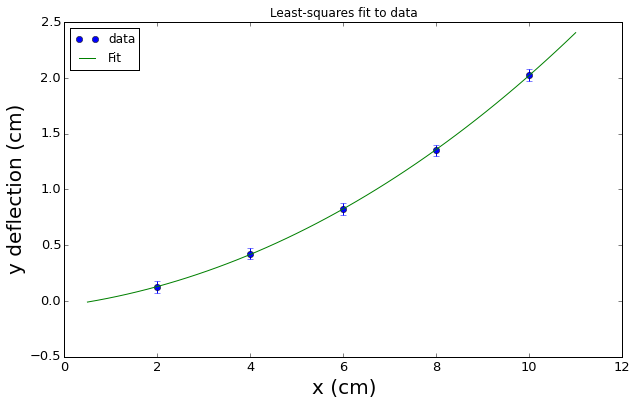

In [45]:
plt.figure(figsize=(10,6));
plt.errorbar(xpoints[1]*100,ypoints[1]*100,y_uncertainty[1]*100,linestyle = '',marker = 'o');
plt.xlabel('x (mm)');
plt.ylabel('y (mm)');
plt.plot(xlots*100,yfit[1]*100);
plt.title('Least-squares fit to data');
plt.legend(['data','Fit'],loc='best');
plt.xlabel('x (cm)',fontsize=20);
plt.ylabel('y deflection (cm)',fontsize = 20);
plt.xlim(0,12);
plt.xticks(size = 13);
plt.yticks(size = 13);
plt.savefig('Sample')

## Calculating e/m

From the Lorentz force law,

\begin{equation*}
\frac{e}{m} = \frac{2V_a}{B^2 r^2} 
\end{equation*}

and the magnetic field of a Helmholtz coil,
\begin{equation*}
B = \frac{16 {\mu}_o N I}{\sqrt{125}D} 
\end{equation*}

we calculate the charge per mass in terms of measured quantities,
\begin{equation*}
\frac{e}{m} = \frac{125}{128}\frac{V_a D^2}{{{\mu}_o}^2 N^2 I^2 r^2} 
\end{equation*}

In [46]:
mu_o = 4*np.pi*1e-7
D = 21.3*1e-2
D_uncertainty = 1e-3
N=124

acceptedvalue = 1.76*1e11 #C/kg

eperm = np.array([(125/128)*voltages[i]*(D**2)/( (mu_o**2)*(N**2)*(currents[i]**2)*(a[i]**2) ) for i in np.arange(0,len(xpoints))])

## Plot vs Accepted Value

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


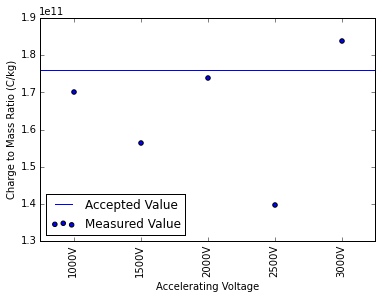

In [14]:
plt.scatter(np.arange(0,len(xpoints)),eperm);
xplaces = np.linspace(-.5,5.5,50);
plt.plot(xplaces,np.array([acceptedvalue]*len(xplaces)));
plt.xlim(-.5,4.5);
plt.legend(['Accepted Value','Measured Value'],loc='lower left');
plt.ylabel('Charge to Mass Ratio (C/kg)');
plt.xlabel('Accelerating Voltage')
labels = np.array([(str(entry)+'V') for entry in voltages]);
plt.xticks(np.arange(0,len(xpoints)), labels, rotation='vertical');

## Uncertainty

In [15]:
std = np.std(eperm)
std

15270897668.044897

In [16]:
u = (np.array([np.sqrt(np.sqrt( (v_uncertainty/voltages[i])**2 + 4*(i_uncertainty/currents[i])**2 + 4*(ea[0]/a[0])**2 + 
                                  4*(D_uncertainty/D)))*eperm[i] for i in np.arange(0,len(voltages))]))
avg_u = np.mean(u)

In [17]:
mean_std = avg_u/np.sqrt(len(xpoints))

## Results

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


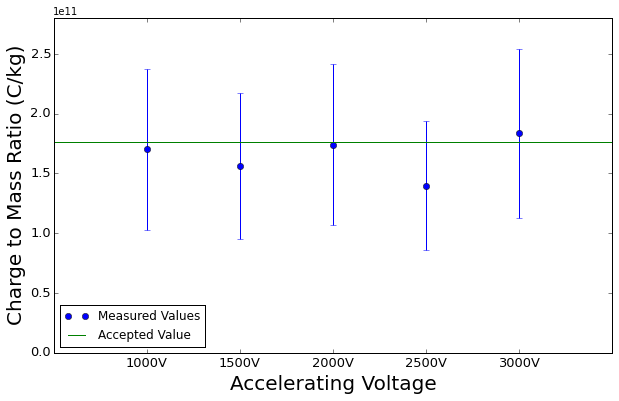

In [52]:
plt.figure(figsize=(10,6));
plt.errorbar(np.arange(0,len(xpoints)),eperm,u, linestyle = '',marker = 'o');
xplaces = np.linspace(-1,5.5,50);
plt.plot(xplaces,np.array([acceptedvalue]*len(xplaces)));
plt.xlim(-1,5);
plt.ylim(0,2.8*1e11)
plt.legend(['Measured Values','Accepted Value'],loc='lower left');
plt.ylabel('Charge to Mass Ratio (C/kg)',size=20);
plt.xlabel('Accelerating Voltage',size=20)
labels = np.array([(str(entry)+'V') for entry in voltages]);
plt.xticks(np.arange(0,len(xpoints)), labels,size=13);
plt.yticks(size=13);
plt.savefig('Results')

In [19]:
np.mean(eperm)

164819847874.82666

In [20]:
mean_std

28677000225.926479

## Final Value

In [21]:
print('e/m = (%.3f +/- %.3f)x%s C/kg' % (np.mean(eperm)/1e11, mean_std/1e11,1e11))

e/m = (1.648 +/- 0.287)x100000000000.0 C/kg


In [22]:
acceptedvalue/1e11

1.76

## Plot Accelerating Voltage vs Square of Current

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


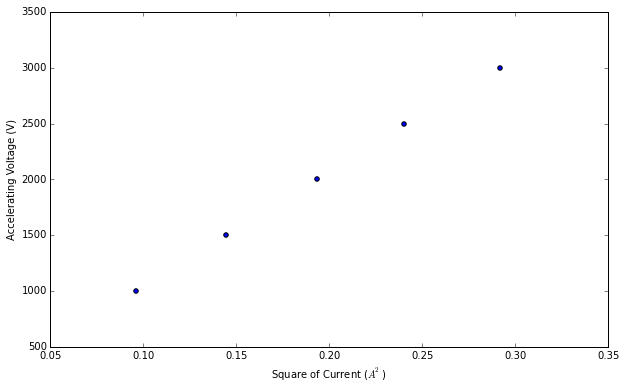

In [92]:
plt.figure(figsize=(10,6));
plt.scatter(currents**2,voltages);
plt.ylabel('Accelerating Voltage (V)');
plt.xlabel('Square of Current ($A^2$)');

In [117]:
def myfun(x,qpm): #Where x is (I*r) and qpm = e/m
    ans = qpm*(128/125)*(mu_o**2)*(N**2)*(1/D**2)*x # this is y, "the function to be fit"
    return ans

In [118]:
p0 = [acceptedvalue]

In [126]:
(currents*a)**2

array([ 0.01073002,  0.01748897,  0.02097153,  0.03263509,  0.02979331])

In [141]:
xlots = np.linspace(.01,.035)  # need lots of data points for smooth curve

plsq, pcov = curve_fit(myfun, (currents*a)**2, voltages, p0)  # curve fit returns p and covariance matrix
# these give the parameters and the uncertainties
epm = plsq[0]
eepm = np.sqrt(pcov[0,0])

yfit = myfun(xlots,epm)  # use fit results for a, b, c
    
print('epm = %.3f +/- %.3f' % (plsq[0]/1e11, np.sqrt(pcov[0,0])/1e11))

epm = 1.621 +/- 0.095


In [142]:
epm/acceptedvalue

0.9207868101803206

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


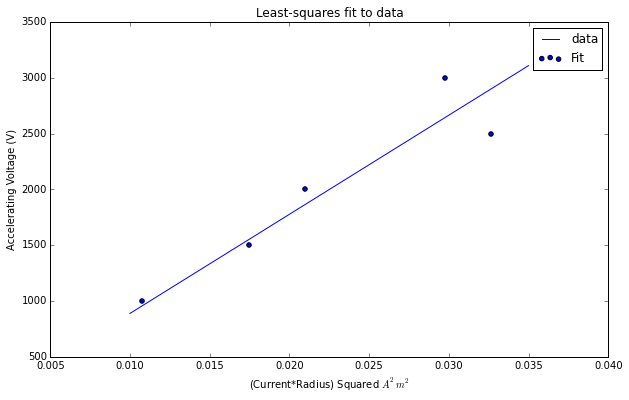

In [140]:
plt.figure(figsize=(10,6));
plt.scatter((currents*a)**2,voltages);
plt.ylabel('Accelerating Voltage (V)');
plt.xlabel('(Current*Radius) Squared $A^2$$m^2$');
plt.plot(xlots,yfit);
plt.title('Least-squares fit to data');
plt.legend(['data','Fit'],loc='best');